# Bilayer graphene under a superlattice electrostatic potential
We obtain the band structure of bilayer graphene (BLG) under a electrostatic potential repeated in the form of a square lattice.

In [1]:
# Imports 
%matplotlib inline
# to install pybandstructure uncomment and run the following line
# ! pip3 install pybandstructure
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
import matplotlib as mpl
import pybandstructure as pb
from scipy.special import j1
from tqdm import tqdm

print('pybandstructure version = {}'.format(pb.__version__))

pybandstructure version = 2.0


We need to solve the Schrödinger equation for the Hamiltonian of BLG under an electrostatic potential. We will consider the low-energy two band tight binding model of this Hamiltonian ($H_{blg}$), and the effect of the potential is taken in the Hamiltonian term for the interlayer assymetry ($H_{\Delta}$) and the average potential $H_V$.

$$H({\bf k}) = H_{blg}({\bf k}) +H_V + H_{\Delta} $$

It is convenient to write the Hamiltonian in the $\mathbf{k}$ space, as the input of the program takes them in this form. Therefore, the different Hamiltonians read

$$ H_{blg}({\bf k}) = -\frac{\hbar^2}{2m} 
\begin{bmatrix}
0 & (k_x-ik_y)^2 \\
(k_x+ik_y )^2& 0 \\
\end{bmatrix}$$

$$ H_{V} =  
\sum_{\bf G }V_{\bf G}e^{i \bf G \cdot \hat{\bf r}}\begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix}$$

$$ H_{\Delta} =  
\sum_{\bf G }\Delta_{\bf G}e^{i \bf G \cdot \hat{\bf r}}\begin{bmatrix}
1/2 & 0 \\
0 & -1/2 \\
\end{bmatrix}$$



where $V_\mathbf{G}$ and $\Delta_\mathbf{G}$ are the Fourier components of the average potential and the interlayer asymmetry in the reciprocal lattice point $\mathbf{G}$, respectively.

\begin{equation}
    \langle \mathbf{k}, \mathbf{G}, \lambda |H| \mathbf{k}, \mathbf{G}', \lambda' \rangle
    = -\alpha \delta_{{\bf G G'}} \chi_\lambda^\dagger 
    \begin{bmatrix}
    0 & [k_x+G_x-i(k_y+G_y)]^2 \\ 
    [k_x+G_x+i(k_y+G_y)]^2  & 0
    \end{bmatrix}\chi_{\lambda'}  + \chi_\lambda^\dagger \begin{bmatrix}
    V_{\mathbf{G'-G}} + \frac{\Delta_{\mathbf{G'-G}}}{2} & 0 \\
    0 & V_{\mathbf{G'-G}}- \frac{\Delta_{\mathbf{G'-G}}}{2} 
    \end{bmatrix} \chi_{\lambda'},
\end{equation}
 


## Definition of the simulation parameters
We start by defining the different parameters needen for the problem, where all the energies are in eV, and the distances in nm.
These include $m$ the effective mass of charge carriers in BLG and the parameters of the potential. We choose that the repeated potential is the circular well considered un the example of the Confined states and Hubbard parameter calculation, i.e., $V(\rho)$= 0 and an interlayer assymetry of

$\Delta(\rho)$ = $\Delta_{out}$ if $\rho$ > $\rho_0$, and 

$\Delta(\rho)$ = $\Delta_{in}$ if $\rho$ < $\rho_0$.

The periodic repetition of this potential can be rewriten in the form:

$$ \Delta(\mathbf{r}) = \sum_\mathbf{R} \Delta_{\text{dot}}(|{\bf r-R}|) + \Delta_{out} $$

where $\Delta_{dot}(\mathbf{r}) = (\Delta_{in} - \Delta_{out}) \theta(\rho_0 -\rho)$ and $\mathbf{R}$ is the lattice vector of the superlattice (of the potential).

We define these last defined parameters so that they are the same as the ones considered in the other example.

In [2]:
#################### bilayer graphene parameters ###############################
alpha = 1.27  # the alpha defined in the work, 
m = 1/(2.*alpha) # m/hbar**2 [eV^-1 nm^-2]
#################### potential ################################################
r0 = 20 # dot radius nm
delta_in = 0.025  # eV
delta_out = 0.05
v_in = 0  # eV
v_out = 0

#################### post-procesing parameters #################################
density = 0.0 #electron density in [nm^-2]
temperature = 0.0 # k_B T in eV
eta = 0.005 # energy smoothing [eV]


## Definition of the supperlattice
We choose to have an square lattice of quantum dots. Thus, $\mathbf{R}=n_1 \mathbf{a_1} + n_2 \mathbf{a_2}$ is the lattice vector that defines the periodicity of the potential, given that $n_1, n_2 \in \mathbb{Z}$, and $\mathbf{a_1}$ and $\mathbf{a_2}$ are the primitive lattice vectors, that in this case are $\mathbf{a_1}=a(1, 0)$ and $\mathbf{a_2} = a(0, 1)$; being $a$ the lattice constant.
We now proceed to define this lattice constan and the geometry of the supperlattice, where for this last we create Crystal_geometry object.

We also define here the computational parameters, as changing the lattice parameter also changes the band structure, and thus the bands we need to compute to fill the same energy range.

We diferenciate in two cells the two different cases considered in the thesis. Uncomment the a=150 case and comment the a=50 one to see the case with negligible interactions.

In [3]:
######################### a = 50 ###########################################
#################### superlattice parameters ###################################
a = 50  # superlattice constant [nm]
################################ computational parameters ######################
n_sites = 20  # number of points in the full Brillouin zone
n_bands = 60  # number of bands to retain (above and below Dirac point) 
G_max = 6.001  # number of shells of reciprocal spaces

In [4]:
# ######################### a = 150 ###########################################
# #################### superlattice parameters ###################################
# a = 150 # superlattice constant [nm]
# ################################ computational parameters ######################
# n_sites = 20  # number of points in the full Brillouin zone
# n_bands = 190  # number of bands to retain (above and below Dirac point) 
# G_max = 8.001  # number of shells of reciprocal spaces


In [5]:
# We store the geometry here: in our case, square lattice.
geometry = pb.Crystal_Geometry(
    translation_vectors = a * np.array([[1, 0],
                                        [0, 1]]),   # primitive lattice vectors, in collumns
    point_group = pb.Point_Group.dihedral_group(n = 4, theta0 = 0)  # Symmetries of the square lattice: D4
    )

We define samplings of Brillouin zone and reciprocal lattice

In [6]:
k_sample = pb.sample.Unit_Cell_Sample.irreducible_sample(name = '2D_Square_D4',basis_vectors = geometry.reciprocal_lattice_basis, denominator=n_sites)
    
G = lin.norm(geometry.reciprocal_lattice_basis[:,0])
reciprocal_lattice_vectors = pb.sample.Sample.lattice_sample(basis_vectors = geometry.reciprocal_lattice_basis, 
                                                             cut_off = G_max * G)  #the cuttof is the norm of the first vector times G_max by def.

We now plot the different samplings (to check them): in real space and reciprocal space.

<Axes: >

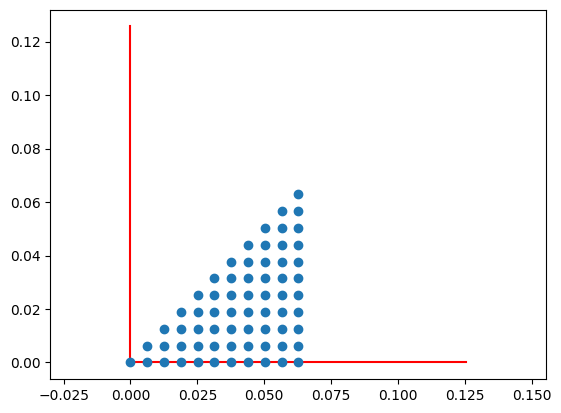

In [7]:
k_sample.plot()  # check the sampling

<Axes: >

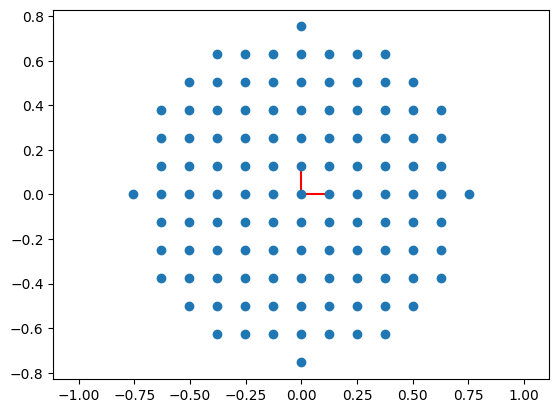

In [8]:
reciprocal_lattice_vectors.plot()  # check the reciprocal lattice

## Definition of the Hamiltonians: bilayer 2x2 Hamiltonian under an inhomogeneous potential.
Having defined the sampling of the superlattice, we need the total Hamiltonian that defines the system to analyze. In our case, we have the sum described above. The momentums (derivatives of the Hamiltonian) only correspond to the bilayer graphene, as the potential and the interlayer asymmetry are homogeneous.  We proceed to define these 3 Hamiltonians $H_{blg}, H_V, H_{\Delta}$ following the equations at the beginning of this file.

### Hamiltonian of the bilayer
This constitutes the diagonal part of the total matrix. This is the kinetic part of our Hamiltonian, so we need to use the "build kinetic term" function.

In [9]:
class f_bilayer:
    def __init__(self, m, der = (0,0)):
        self.m = m
        self.der = der
    def __call__(self, k):
        if self.der == (0,0):
            return [-(k[0]**2-k[1]**2)/(2.*self.m), -(2*k[0]*k[1])/(2.*self.m)]
        if self.der == (1,0):
            return [-(2*k[0])/(2.*self.m), -(2*k[1])/(2.*self.m)]  # derivative with respect to k_x
        if self.der == (0,1):
            return [-(-2*k[1])/(2.*self.m), -(2*k[0])/(2.*self.m)] # derivative with respect to k_y
        else:
            raise NotImplementedError

        
M_x = pb.pauli_matrix('x')  # Pauli matrices
M_y = pb.pauli_matrix('y')

# H_{blg}(k)  (Dirac hamiltonian)
H_bilayer = pb.build_kinetic_term(H = [M_x, M_y], 
                           f = f_bilayer(m=m,der=(0,0)), 
                           reciprocal_lattice_vectors = reciprocal_lattice_vectors)

# Momentum operators 
p_x = pb.build_kinetic_term([M_x, M_y], 
                           f = f_bilayer(m=m,der=(1,0)), 
                           reciprocal_lattice_vectors = reciprocal_lattice_vectors)
p_y = pb.build_kinetic_term([M_x, M_y], 
                           f = f_bilayer(m=m,der=(0,1)), 
                           reciprocal_lattice_vectors = reciprocal_lattice_vectors)

For the interlayer asymmetry and the potential, we need the Fourier components of the defined potentials.
### Interlayer asymmetry Hamiltonian
\begin{equation}
    \Delta_{\mathbf{G}} =\int_{u.c.} \frac{ d^2 \mathbf{r} }{S_{u.c.}}
    \Delta (\mathbf{r}) e^{-i \mathbf{G} \cdot \mathbf{r}} 
    = \Delta_{out} \; \delta_{\mathbf{G}, 0} -\int_0^\infty \rho d\rho \int_{-\pi}^{+\pi} d\theta \frac{\Delta_{in}- \Delta_{out}}{S_{u.c.}} \; \theta(\rho_0 - \rho) e^{-iGr\cos{\theta}}
    = \Delta_{out} \; \delta_{\mathbf{G}, 0} -
    \frac{\Delta_{in}- \Delta_{out}}{S_{u.c.}} \frac{2\pi \rho_0}{G} J_1(G \rho_0),
\end{equation}
where S_{u.c.} is the area of the unir cells and $J_1(x)$ is the first Bessel function of the first kind.

In [10]:
def muffin_tin(q, r0, smoothing = 0):  # J_1(q*r0)
    """
    The fourier tranform component in |k| = q (answer of the integral) of a muffin tin function of radius r0.
    """
    if q > 0:
        return 2 *np.pi *r0 / q * j1(r0 * q) * np.exp(-q**2 * smoothing**2)
    elif q == 0.:
        return np.pi *r0**2
    else:
        raise ValueError

In [11]:
# Vector to store the Fourier components
gap_potential = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)

for i in range(len(reciprocal_lattice_vectors)):
    q = np.linalg.norm(reciprocal_lattice_vectors.coords[i])
    gap_potential[i] = muffin_tin(q, r0,smoothing=2)*(delta_in-delta_out)/geometry.unit_cell_volume # each of the components

gap_potential[reciprocal_lattice_vectors[(0, 0)]] += delta_out
M_z = pb.pauli_matrix('z')
H_delta = pb.build_potential_hamiltonian(U = M_z/2, 
                                potential_components = gap_potential, 
                                reciprocal_lattice_vectors = reciprocal_lattice_vectors)

### Average potential
We have chosen a constant null potential. Therefore, all the components are 0. We could ommit this part, but we leave it if someone want to try different potentials. 

In [12]:
# Vector to store the Fourier components
scalar_potential = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)
scalar_potential[reciprocal_lattice_vectors[(0, 0)]] = 0.0

M_id = np.identity(2, dtype = complex)
H_v = pb.build_potential_hamiltonian(U = M_id, 
                                potential_components = scalar_potential, 
                                reciprocal_lattice_vectors = reciprocal_lattice_vectors)

## Initialize the crystal and perform the corresponding calculations

We first initialize the crystral from the Hamiltonian. For that, we inizialize a Band_Structure specifying all the components we have calculated (the Hamiltonians and the k sample) and other variables we defined in the beggining. Then, we initialize the crystal by providing the geometry, the band structure and eta, a parameter that serves for some integrals so that it defines the smoothness of the calculations (and can then be changed).

In [13]:
band_structure = pb.Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                 hamiltonian = H_bilayer + H_delta + H_v,
                                                 momentum_operator= [p_x,p_y],
                                                 degeneracy = 4,  #spin and valley
                                                 zero_filling = n_bands,
                                                 density = density, #electron density
                                                 temperature = temperature)
blg = pb.Crystal(geometry=geometry, band_structure= band_structure, eta=eta)

We compute the bands in this way (we specify the limits of the eigenvalues to be calculated)

In [14]:
blg.band_structure.compute_bands(eigvals = (2 * len(reciprocal_lattice_vectors) // 2 - n_bands,
                                        2 * len(reciprocal_lattice_vectors) // 2 + n_bands - 1))
#blg.band_structure.compute_momentum_matrix()

100%|███████████████████████████████████████████████████████████████████████████████████| 66/66 [00:07<00:00,  9.41it/s]


Finally, we plot the bands. We first print the special points to do the countour string and then plot them.

In [15]:
k_sample.special_points

{'$\\Gamma$': (0, 0), '$X$': (10, 0), '$M$': (10, 10)}

In [16]:
cmap1 = mpl.colormaps['spring']
cmap2 = mpl.colormaps['winter']
cmap3 = mpl.colormaps['summer']
cmap4 = mpl.colormaps['autumn']

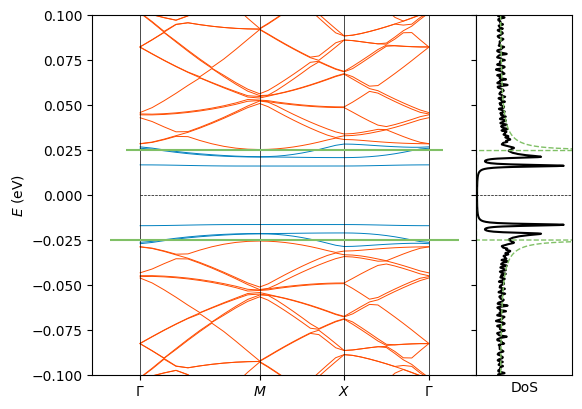

In [17]:
blg.eta = 0.0005
contour_str = ['$\Gamma$','$M$','$X$', '$\Gamma$']
fig_lims= -0.1,0.1
##############################################
e_lims = np.amin(blg.band_structure.energies), np.amax(blg.band_structure.energies)
e_vals = np.linspace(*e_lims,num=5000)
dos_vals = blg.dos(e_vals)

plt.axes([0.2,0.2,0.6,0.75])
bands, _, _=blg.band_structure.plot(contour_str, c=cmap4(0.3), lw=0.7)

central_band = int(len(bands)/2)
for index in range(central_band-3, central_band+3):
    bands[index][0].set(color=cmap2(0.5))
ax1 =plt.gca()

plt.ylim(*fig_lims)
plt.ylabel(r'$E ~(\rm eV)$')
plt.hlines(delta_out/2, *ax1.get_xlim(), color=cmap3(0.5))
plt.hlines(-delta_out/2, *ax1.get_xlim(), color=cmap3(0.5))
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_xlabel(r'DoS')

plt.plot(dos_vals ,e_vals, c='k')
plt.plot((2*m)/(np.pi)*np.real(abs(e_vals)/np.sqrt(e_vals**2-(delta_out/2)**2+0.j)),e_vals,'--', c=cmap3(0.5), lw=1)

plt.plot([0,1.1*np.amax(dos_vals)],[blg.band_structure.chemical_potential,blg.band_structure.chemical_potential],'--',c='k', lw=0.5)
plt.ylim(*fig_lims)
plt.xlim(0,1.1*np.amax(dos_vals))
plt.show()


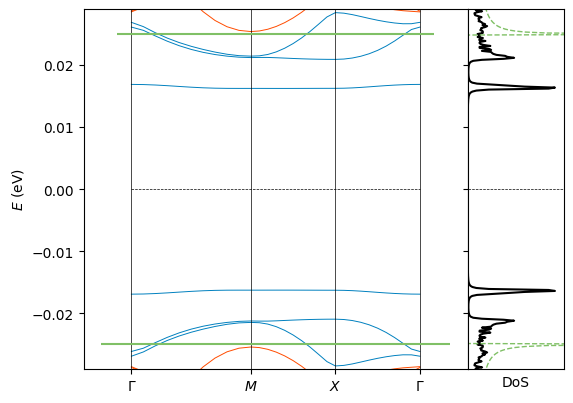

In [18]:
blg.eta = 0.0001
contour_str = ['$\Gamma$','$M$','$X$', '$\Gamma$']
fig_lims= -0.029,0.029
##############################################
e_lims = np.amin(blg.band_structure.energies), np.amax(blg.band_structure.energies)
e_vals = np.linspace(*e_lims,num=5000)
dos_vals = blg.dos(e_vals)

plt.axes([0.2,0.2,0.6,0.75])
bands, _, _=blg.band_structure.plot(contour_str, c=cmap4(0.3), lw=0.7)

central_band = int(len(bands)/2)
for index in range(central_band-3, central_band+3):
    bands[index][0].set(color=cmap2(0.5))
ax1 =plt.gca()

plt.ylim(*fig_lims)
plt.ylabel(r'$E ~(\rm eV)$')
plt.hlines(delta_out/2, *ax1.get_xlim(), color=cmap3(0.5))
plt.hlines(-delta_out/2, *ax1.get_xlim(), color=cmap3(0.5))
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_xlabel(r'DoS')

plt.plot(dos_vals ,e_vals, c='k')
plt.plot((2*m)/(np.pi)*np.real(abs(e_vals)/np.sqrt(e_vals**2-(delta_out/2)**2+0.j)),e_vals,'--', c=cmap3(0.5), lw=1)

plt.plot([0,1.1*np.amax(dos_vals)],[blg.band_structure.chemical_potential,blg.band_structure.chemical_potential],'--',c='k', lw=0.5)
plt.ylim(*fig_lims)
plt.xlim(0,1.1*np.amax(dos_vals))
plt.show()